# Business Understanding
- Telecommunications company interested in reducing money lost with people churning
- We were tasked with building models to be able to accurately predict the probability of a person churning
- This will help the Telecommunications to predict when it will lose customers 
- Based on the model it will identify what importance features are useful to tell when a person will churn


# Data Understanding
- This data is from a telecom company
- It contains customer usage in minutes and calls
- Whether the customer churned or didnt churn
- Whether or not they had an international, voicemail plan and how many times they called customer service
- All of this is useful and insightful information if a customer is going to churn

# Data Preperation

In [133]:
#Importing packages to be used throughout the project
import pandas as pd
import numpy as np
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import confusion_matrix, recall_score, precision_score
import matplotlib.pyplot as plt
from sklearn import set_config
set_config(display='diagram')
from sklearn.preprocessing import OneHotEncoder, StandardScaler, MaxAbsScaler
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, roc_curve, RocCurveDisplay, ConfusionMatrixDisplay, confusion_matrix, plot_roc_curve
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from imblearn.pipeline import Pipeline
from imblearn.over_sampling import SMOTE, RandomOverSampler
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier

In [105]:
#reading the data and saving it to a variable
df = pd.read_csv('bigml_59c28831336c6604c800002a.csv')

In [106]:
#Checking out if there are any nulls
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3333 entries, 0 to 3332
Data columns (total 21 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   state                   3333 non-null   object 
 1   account length          3333 non-null   int64  
 2   area code               3333 non-null   int64  
 3   phone number            3333 non-null   object 
 4   international plan      3333 non-null   object 
 5   voice mail plan         3333 non-null   object 
 6   number vmail messages   3333 non-null   int64  
 7   total day minutes       3333 non-null   float64
 8   total day calls         3333 non-null   int64  
 9   total day charge        3333 non-null   float64
 10  total eve minutes       3333 non-null   float64
 11  total eve calls         3333 non-null   int64  
 12  total eve charge        3333 non-null   float64
 13  total night minutes     3333 non-null   float64
 14  total night calls       3333 non-null   

In [107]:
#Looking at the numeric features and that they are not on the same scale
df.describe()

,account length,area code,number vmail messages,total day minutes,total day calls,total day charge,total eve minutes,total eve calls,total eve charge,total night minutes,total night calls,total night charge,total intl minutes,total intl calls,total intl charge,customer service calls
count,3333.000000,3333.000000,3333.000000,3333.000000,3333.000000,3333.000000,3333.000000,3333.000000,3333.000000,3333.000000,3333.000000,3333.000000,3333.000000,3333.000000,3333.000000,3333.000000
mean,101.064806,437.182418,8.099010,179.775098,100.435644,30.562307,200.980348,100.114311,17.083540,200.872037,100.107711,9.039325,10.237294,4.479448,2.764581,1.562856
std,39.822106,42.371290,13.688365,54.467389,20.069084,9.259435,50.713844,19.922625,4.310668,50.573847,19.568609,2.275873,2.791840,2.461214,0.753773,1.315491
min,1.000000,408.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,23.200000,33.000000,1.040000,0.000000,0.000000,0.000000,0.000000
25%,74.000000,408.000000,0.000000,143.700000,87.000000,24.430000,166.600000,87.000000,14.160000,167.000000,87.000000,7.520000,8.500000,3.000000,2.300000,1.000000
50%,101.000000,415.000000,0.000000,179.400000,101.000000,30.500000,201.400000,100.000000,17.120000,201.200000,100.000000,9.050000,10.300000,4.000000,2.780000,1.000000
75%,127.000000,510.000000,20.000000,216.400000,114.000000,36.790000,235.300000,114.000000,20.000000,235.300000,113.000000,10.590000,12.100000,6.000000,3.270000,2.000000
max,243.000000,510.000000,51.000000,350.800000,165.000000,59.640000,363.700000,170.000000,30.910000,395.000000,175.000000,17.770000,20.000000,20.000000,5.400000,9.000000


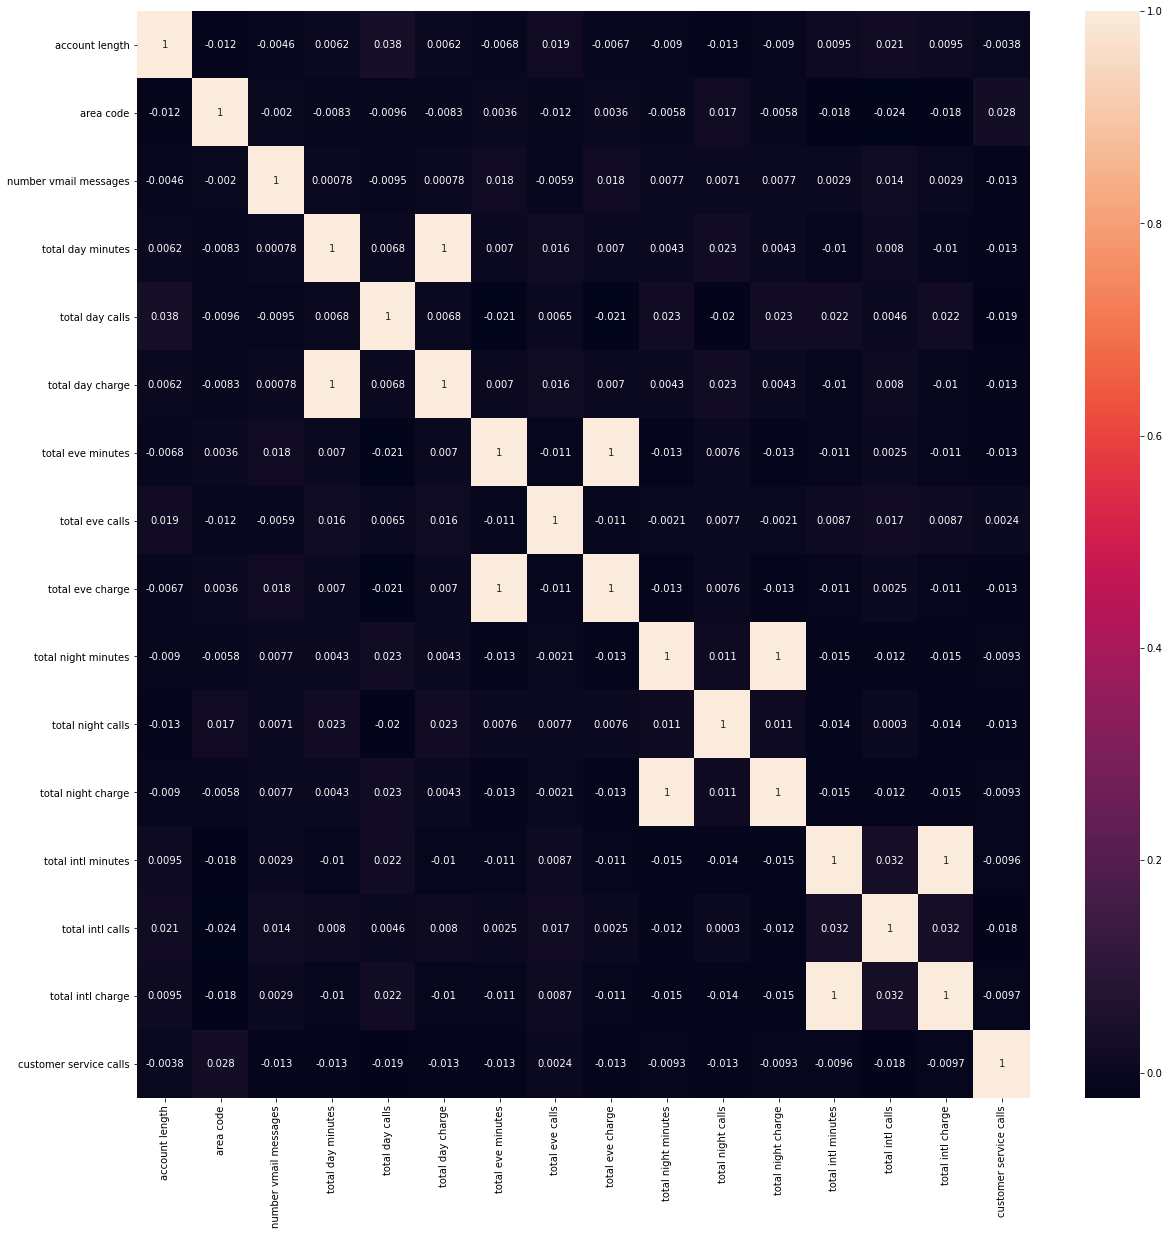

In [108]:
#Plotting a heatmap to see if there is any collinearity in the feature space
fig, ax = plt.subplots(figsize = (20,20))
sns.heatmap(df.drop(columns = ['state','phone number', 'international plan', 'voice mail plan', 'churn']).corr(), annot = True);

In [109]:
#Dropping columns that have collinearity with other columns
df.drop(columns = ['phone number', 'total day charge', 'total eve charge','total night charge', 'total intl charge'], inplace = True)

In [110]:
#Looking at the value counts of our target variable and notice that there is a class imbalance
df['churn'].value_counts()

False    2850
True      483
Name: churn, dtype: int64

In [111]:
#Label enconding the target variable
le = LabelEncoder()
le.fit(df['churn'])
df['churn'] = le.transform(df['churn'])

Train Test Split

In [112]:
#Seperating the target and predictor variables and running a train test split
X = df.drop(columns = "churn", axis = 1)
y = df['churn']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = .2, random_state = 24)

## 1. FSM - Logistic Regression

In [113]:
#Creating a first simple model with Logistic Regression
nominal_pipeline = Pipeline([('one_hot', OneHotEncoder()), ('mm_scaler', MaxAbsScaler())])
numeric_pipeline = Pipeline([(('std_scaler'), StandardScaler())])
num_cols = X_train.select_dtypes(['int', 'float']).columns
ct = ColumnTransformer([('nominalpipe', nominal_pipeline, ['state', 'area code', 'international plan', 'voice mail plan']), 
                        ('numpipe', numeric_pipeline, num_cols)])
pipe = Pipeline([('preprocessing', ct), ('model', LogisticRegression(random_state = 24))])

In [114]:
#Training the model on the train data set
pipe.fit(X_train, y_train)

Pipeline(steps=[('preprocessing',
                 ColumnTransformer(transformers=[('nominalpipe',
                                                  Pipeline(steps=[('one_hot',
                                                                   OneHotEncoder()),
                                                                  ('mm_scaler',
                                                                   MaxAbsScaler())]),
                                                  ['state', 'area code',
                                                   'international plan',
                                                   'voice mail plan']),
                                                 ('numpipe',
                                                  Pipeline(steps=[('std_scaler',
                                                                   StandardScaler())]),
                                                  Index(['total day minutes', 'total eve minutes', 'total night minutes',
       'total intl minutes'],
      dtype='object'))])),
                ('model', LogisticRegression(random_state=24))])

In [115]:
#Looking at the classification metrics specifically the recall score
#Recall for the positive class is very poor
y_pred_fsm = pipe.predict(X_train)
print(classification_report(y_train, y_pred_fsm))

              precision    recall  f1-score   support

           0       0.88      0.99      0.93      2283
           1       0.67      0.17      0.27       383

    accuracy                           0.87      2666
   macro avg       0.78      0.58      0.60      2666
weighted avg       0.85      0.87      0.83      2666



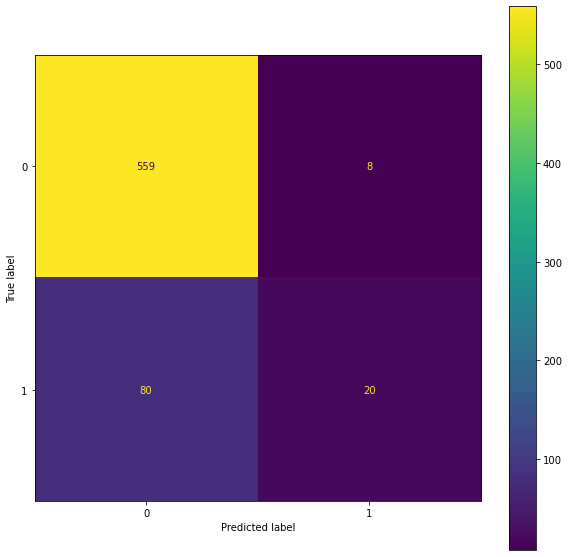

In [122]:
fig, ax = plt.subplots(figsize = (10,10))
cm = confusion_matrix(y_test, pipe.predict(X_test))
ConfusionMatrixDisplay(cm).plot(ax = ax);

## Creating a Logistic Regression model with a class balance

In [137]:
#Creating a new Logistic Regression with smote and random over sampler as our class balancers
smote = SMOTE(random_state = 24)
ros = RandomOverSampler(random_state = 24)
nominal_pipeline = Pipeline([('one_hot', OneHotEncoder()), ('maxab_scaler', MaxAbsScaler())])
numeric_pipeline = Pipeline([(('std_scaler'), StandardScaler())])
num_cols = X_train.select_dtypes(['int', 'float']).columns
ct = ColumnTransformer([('nominalpipe', nominal_pipeline, ['state', 'area code','international plan', 'voice mail plan']), 
                        ('numpipe', numeric_pipeline, num_cols)])
ros_pipe = Pipeline([('preprocessing', ct), ('sampling', ros), ('model', LogisticRegression(random_state = 24, max_iter = 10*100))])


In [138]:
#Fitting the model on the train data
ros_pipe.fit(X_train, y_train)

Pipeline(steps=[('preprocessing',
                 ColumnTransformer(transformers=[('nominalpipe',
                                                  Pipeline(steps=[('one_hot',
                                                                   OneHotEncoder()),
                                                                  ('maxab_scaler',
                                                                   MaxAbsScaler())]),
                                                  ['state', 'area code',
                                                   'international plan',
                                                   'voice mail plan']),
                                                 ('numpipe',
                                                  Pipeline(steps=[('std_scaler',
                                                                   StandardScaler())]),
                                                  Index(['total day minutes', 'total eve minutes', 'total night minutes',
       'total intl minutes'],
      dtype='object'))])),
                ('sampling', RandomOverSampler(random_state=24)),
                ('model', LogisticRegression(max_iter=1000, random_state=24))])

In [139]:
#Looking at the classification metrics for the train data
fsm_ros = ros_pipe.predict(X_train)
print(classification_report(y_train, fsm_ros))

              precision    recall  f1-score   support

           0       0.93      0.74      0.83      2283
           1       0.31      0.68      0.42       383

    accuracy                           0.73      2666
   macro avg       0.62      0.71      0.62      2666
weighted avg       0.84      0.73      0.77      2666



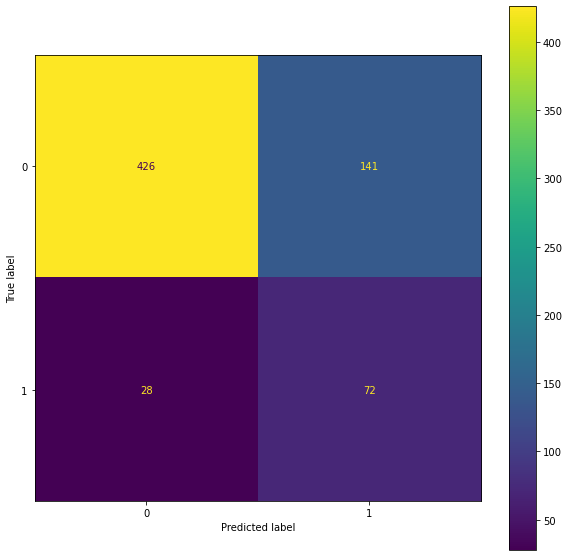

In [140]:
fig, ax = plt.subplots(figsize = (10,10))
cm2 = confusion_matrix(y_test, ros_pipe.predict(X_test))
ConfusionMatrixDisplay(cm2).plot(ax = ax);

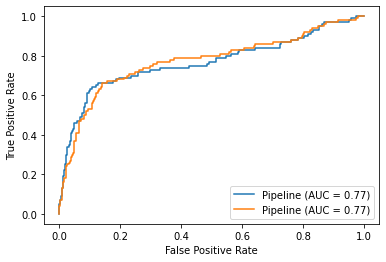

In [136]:
fig, ax = plt.subplots()
plot_roc_curve(pipe, X_test, y_test, ax = ax)
plot_roc_curve(ros_pipe, X_test, y_test, ax = ax);

## 2. Random Forest Model  Baseline

In [23]:
#Creating a new pipeline using the RandomForestClassifier
second_nominalpipe = Pipeline([('one_hot', OneHotEncoder())])
ctRF = ColumnTransformer([('secondnominalpipe', second_nominalpipe, ['state', 'area code', 'international plan', 'voice mail plan'])], remainder = 'passthrough')                         
secondpipe = Pipeline([('preprocessing', ctRF), ('sampling', ros), ('model', RandomForestClassifier(random_state = 24))])

In [25]:
#Fitting the pipeline
secondpipe.fit(X_train, y_train)

Pipeline(steps=[('preprocessing',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('secondnominalpipe',
                                                  Pipeline(steps=[('one_hot',
                                                                   OneHotEncoder())]),
                                                  ['state', 'area code',
                                                   'international plan',
                                                   'voice mail plan'])])),
                ('sampling', RandomOverSampler(random_state=24)),
                ('model', RandomForestClassifier(random_state=24))])

In [26]:
#Predicting on the train data
RF_predict = secondpipe.predict(X_train)
print(classification_report(y_train, RF_predict))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00      2283
           1       1.00      1.00      1.00       383

    accuracy                           1.00      2666
   macro avg       1.00      1.00      1.00      2666
weighted avg       1.00      1.00      1.00      2666



## Overfitting
- We got great scores for our train set! This is a red flag
- We didnt give the RandomForestClassifier a maximum depth so it ran till there were pure leafs
 - This results in overfitting

## Random Forest Random Search Model

In [27]:
#Creating grid parameters for a RandomizedSearchCV
RFgrid = [{"model__criterion" : ["gini", "entropy"],
           "model__n_estimators": [10, 30, 60, 80, 100],
                "model__max_depth": [2,3,4,5,6,8,10, None],
                "model__min_samples_split": [2,5, 6, 8, 10],
                "model__min_samples_leaf": [1,2,3,4,5,6, 10, 15],
         'sampling__sampling_strategy': [.7, .9, 1]}
       ]

In [28]:
#Instantiating the RandomizedSearchCV
RFrandomsearch = RandomizedSearchCV(secondpipe, RFgrid, scoring = 'recall', n_iter = 20, cv = 4)

In [29]:
#Fitting
RFrandomsearch.fit(X_train, y_train)

RandomizedSearchCV(cv=4,
                   estimator=Pipeline(steps=[('preprocessing',
                                              ColumnTransformer(remainder='passthrough',
                                                                transformers=[('secondnominalpipe',
                                                                               Pipeline(steps=[('one_hot',
                                                                                                OneHotEncoder())]),
                                                                               ['state',
                                                                                'area '
                                                                                'code',
                                                                                'international '
                                                                                'plan',
                                                                                'voice '
                                                                                'mail '
                                                                                'plan'])])),
                                             ('sampling',
                                              RandomOverSampler(random_state=24)),
                                             ('model',
                                              RandomForestClassifier(random_state=24))]),
                   n_iter=20,
                   param_distributions=[{'model__criterion': ['gini',
                                                              'entropy'],
                                         'model__max_depth': [2, 3, 4, 5, 6, 8,
                                                              10, None],
                                         'model__min_samples_leaf': [1, 2, 3, 4,
                                                                     5, 6, 10,
                                                                     15],
                                         'model__min_samples_split': [2, 5, 6,
                                                                      8, 10],
                                         'model__n_estimators': [10, 30, 60, 80,
                                                                 100],
                                         'sampling__sampling_strategy': [0.7,
                                                                         0.9,
                                                                         1]}],
                   scoring='recall')

In [30]:
#Creating a dataframe that shows the top 5 best models from RandomSearchCV
randomcv_results = pd.DataFrame(RFrandomsearch.cv_results_)
randomcv_results.sort_values('rank_test_score').head()

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_sampling__sampling_strategy,param_model__n_estimators,param_model__min_samples_split,param_model__min_samples_leaf,param_model__max_depth,param_model__criterion,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,mean_test_score,std_test_score,rank_test_score
9,0.239317,0.003704,0.011724,0.006769,1,80,8,10,8,gini,"{'sampling__sampling_strategy': 1, 'model__n_e...",0.822917,0.833333,0.915789,0.760417,0.833114,0.055281,1
8,0.309945,0.006604,0.013541,0.004070,1,100,8,10,8,entropy,"{'sampling__sampling_strategy': 1, 'model__n_e...",0.812500,0.833333,0.905263,0.760417,0.827878,0.051975,2
3,0.223710,0.005424,0.010929,0.006443,1,60,10,15,None,gini,"{'sampling__sampling_strategy': 1, 'model__n_e...",0.812500,0.843750,0.884211,0.760417,0.825219,0.045234,3
1,0.105048,0.006225,0.007606,0.007612,1,60,2,1,3,gini,"{'sampling__sampling_strategy': 1, 'model__n_e...",0.843750,0.812500,0.884211,0.739583,0.820011,0.052939,4
6,0.346701,0.010069,0.014141,0.004591,1,80,8,10,None,gini,"{'sampling__sampling_strategy': 1, 'model__n_e...",0.812500,0.833333,0.873684,0.760417,0.819984,0.040823,5


In [31]:
#creating a variable for the best estimator
randomRF_best_model = RFrandomsearch.best_estimator_

In [32]:
#Looking at the best parameters for the model
RFrandomsearch.best_params_

{'sampling__sampling_strategy': 1,
 'model__n_estimators': 80,
 'model__min_samples_split': 8,
 'model__min_samples_leaf': 10,
 'model__max_depth': 8,
 'model__criterion': 'gini'}

In [33]:
#Predicting on the X Train
y_pred_RF = randomRF_best_model.predict(X_train)

In [34]:
#Classification metrics on train set
print(classification_report(y_train, y_pred_RF))

              precision    recall  f1-score   support

           0       0.97      0.91      0.94      2283
           1       0.62      0.86      0.72       383

    accuracy                           0.90      2666
   macro avg       0.80      0.88      0.83      2666
weighted avg       0.92      0.90      0.91      2666



In [35]:
#Classification metrics and evaluation on the test set
print(classification_report(y_test, randomRF_best_model.predict(X_test)))

              precision    recall  f1-score   support

           0       0.97      0.88      0.93       567
           1       0.56      0.87      0.69       100

    accuracy                           0.88       667
   macro avg       0.77      0.88      0.81       667
weighted avg       0.91      0.88      0.89       667



In [36]:
#Getting the column names for the OneHotEncoded columns
secondpipe.named_steps['preprocessing'].transformers_[0][1].named_steps['one_hot'].get_feature_names()

array(['x0_AK', 'x0_AL', 'x0_AR', 'x0_AZ', 'x0_CA', 'x0_CO', 'x0_CT',
       'x0_DC', 'x0_DE', 'x0_FL', 'x0_GA', 'x0_HI', 'x0_IA', 'x0_ID',
       'x0_IL', 'x0_IN', 'x0_KS', 'x0_KY', 'x0_LA', 'x0_MA', 'x0_MD',
       'x0_ME', 'x0_MI', 'x0_MN', 'x0_MO', 'x0_MS', 'x0_MT', 'x0_NC',
       'x0_ND', 'x0_NE', 'x0_NH', 'x0_NJ', 'x0_NM', 'x0_NV', 'x0_NY',
       'x0_OH', 'x0_OK', 'x0_OR', 'x0_PA', 'x0_RI', 'x0_SC', 'x0_SD',
       'x0_TN', 'x0_TX', 'x0_UT', 'x0_VA', 'x0_VT', 'x0_WA', 'x0_WI',
       'x0_WV', 'x0_WY', 'x1_408', 'x1_415', 'x1_510', 'x2_no', 'x2_yes',
       'x3_no', 'x3_yes'], dtype=object)

In [37]:
#Creating the variable columns names so that we can use it to see the feature importances
columns_names = ['x0_AK', 'x0_AL', 'x0_AR', 'x0_AZ', 'x0_CA', 'x0_CO', 'x0_CT',
'x0_DC', 'x0_DE', 'x0_FL', 'x0_GA', 'x0_HI', 'x0_IA', 'x0_ID',
'x0_IL', 'x0_IN', 'x0_KS', 'x0_KY', 'x0_LA', 'x0_MA', 'x0_MD',
'x0_ME', 'x0_MI', 'x0_MN', 'x0_MO', 'x0_MS', 'x0_MT', 'x0_NC',
'x0_ND', 'x0_NE', 'x0_NH', 'x0_NJ', 'x0_NM', 'x0_NV', 'x0_NY',
'x0_OH', 'x0_OK', 'x0_OR', 'x0_PA', 'x0_RI', 'x0_SC', 'x0_SD',
'x0_TN', 'x0_TX', 'x0_UT', 'x0_VA', 'x0_VT', 'x0_WA', 'x0_WI',
'x0_WV', 'x0_WY', 'account length', 'x1_408', 'x1_415', 'x1_510', 'x2_no', 'x2_yes',
'x3_no', 'x3_yes', 'number vmail messages', 'total day minutes', 'total day calls',
'total eve minutes', 'total eve calls', 'total night minutes', 'total night calls',
'total intl minutes', 'total intl calls', 'customer service calls']

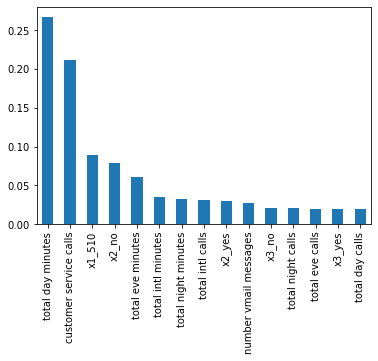

In [38]:
#Creating a plot for the top 15 feature importances of the model which highly influence the target to churn
feature_imp = randomRF_best_model['model'].feature_importances_
feat_imp_series = pd.Series(feature_imp, index = columns_names).sort_values(ascending = False)
feat_imp_series.nlargest(15).plot(kind = 'bar');

In [42]:
#Creating grid paramaters for a GridSearchCV and instantiating GridSearchCV
RFgrid_GS = {'sampling__sampling_strategy': [1],
 'model__n_estimators': [70, 75, 80, 85, 100],
 'model__min_samples_split': [5,7, 8, 9, 10],
 'model__min_samples_leaf': [4, 6, 10, 12],
 'model__max_depth': [None, 5, 6, 8, 10],
 'model__criterion': ['gini', 'entropy']}
RFgridsearch = GridSearchCV(secondpipe, RFgrid_GS, scoring = 'recall', cv = 4)


In [43]:
#Fitting
RFgridsearch.fit(X_train, y_train)

GridSearchCV(cv=4,
             estimator=Pipeline(steps=[('preprocessing',
                                        ColumnTransformer(remainder='passthrough',
                                                          transformers=[('secondnominalpipe',
                                                                         Pipeline(steps=[('one_hot',
                                                                                          OneHotEncoder())]),
                                                                         ['state',
                                                                          'area '
                                                                          'code',
                                                                          'international '
                                                                          'plan',
                                                                          'voice '
                                                                          'mail '
                                                                          'plan'])])),
                                       ('sampling',
                                        RandomOverSampler(random_state=24)),
                                       ('model',
                                        RandomForestClassifier(random_state=24))]),
             param_grid={'model__criterion': ['gini', 'entropy'],
                         'model__max_depth': [None, 5, 6, 8, 10],
                         'model__min_samples_leaf': [4, 6, 10, 12],
                         'model__min_samples_split': [5, 7, 8, 9, 10],
                         'model__n_estimators': [70, 75, 80, 85, 100],
                         'sampling__sampling_strategy': [1]},
             scoring='recall')

In [44]:
#Best parameters
RFgridsearch.best_params_

{'model__criterion': 'gini',
 'model__max_depth': 10,
 'model__min_samples_leaf': 12,
 'model__min_samples_split': 5,
 'model__n_estimators': 75,
 'sampling__sampling_strategy': 1}

In [47]:
#Looking at the pipeline for best estimator
RFgridsearch.best_estimator_

Pipeline(steps=[('preprocessing',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('secondnominalpipe',
                                                  Pipeline(steps=[('one_hot',
                                                                   OneHotEncoder())]),
                                                  ['state', 'area code',
                                                   'international plan',
                                                   'voice mail plan'])])),
                ('sampling',
                 RandomOverSampler(random_state=24, sampling_strategy=1)),
                ('model',
                 RandomForestClassifier(max_depth=10, min_samples_leaf=12,
                                        min_samples_split=5, n_estimators=75,
                                        random_state=24))])

In [46]:
#Creating a variable for the best estimator
best_model = RFgridsearch.best_estimator_

In [48]:
#Predicting on X_train
best_model_pred = best_model.predict(X_train)

In [49]:
#Classification Metrics for train set
print(classification_report(y_train, best_model_pred))

              precision    recall  f1-score   support

           0       0.98      0.92      0.95      2283
           1       0.65      0.88      0.74       383

    accuracy                           0.91      2666
   macro avg       0.81      0.90      0.85      2666
weighted avg       0.93      0.91      0.92      2666



In [50]:
#Classification Metrics and evaluation on the test set
print(classification_report(y_test, best_model.predict(X_test)))

              precision    recall  f1-score   support

           0       0.97      0.88      0.92       567
           1       0.56      0.87      0.68       100

    accuracy                           0.88       667
   macro avg       0.77      0.88      0.80       667
weighted avg       0.91      0.88      0.89       667



In [92]:
#Creating a new pipeline using the XGBClassifier
third_nominalpipe = Pipeline([('one_hot', OneHotEncoder())])
ctxgb = ColumnTransformer([('secondnominalpipe', third_nominalpipe, ['state', 'area code', 'international plan', 'voice mail plan'])], remainder = 'passthrough')                       
thirdpipe = Pipeline([('preprocessing', ctxgb), ('sampling', ros), ('model', XGBClassifier(max_depth = 2, random_state = 24))])

In [93]:
#Fitting
thirdpipe.fit(X_train, y_train)

Pipeline(steps=[('preprocessing',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('secondnominalpipe',
                                                  Pipeline(steps=[('one_hot',
                                                                   OneHotEncoder())]),
                                                  ['state', 'area code',
                                                   'international plan',
                                                   'voice mail plan'])])),
                ('sampling', RandomOverSampler(random_state=24)),
                ('model',
                 XGBClassifier(base_score=0.5, booster='gbtree',
                               colsample_bylevel=1, colsample_...
                               colsample_bytree=1, gamma=0, gpu_id=-1,
                               importance_type='gain',
                               interaction_constraints='',
                               learning_rate=0.300000012, max_delta_step=0,
                               max_depth=2, min_child_weight=1, missing=nan,
                               monotone_constraints='()', n_estimators=100,
                               n_jobs=0, num_parallel_tree=1, random_state=24,
                               reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
                               subsample=1, tree_method='exact',
                               validate_parameters=1, verbosity=None))])

In [94]:
#Predicting on X_train
xgb_y_pred_train = thirdpipe.predict(X_train)

In [95]:
#Metrics on the train set
print(classification_report(y_train, xgb_y_pred_train))

              precision    recall  f1-score   support

           0       0.98      0.95      0.97      2283
           1       0.76      0.89      0.82       383

    accuracy                           0.94      2666
   macro avg       0.87      0.92      0.89      2666
weighted avg       0.95      0.94      0.94      2666



In [96]:
#Metrics and evaluation on the test set
print(classification_report(y_test, thirdpipe.predict(X_test)))

              precision    recall  f1-score   support

           0       0.97      0.93      0.95       567
           1       0.70      0.86      0.77       100

    accuracy                           0.92       667
   macro avg       0.84      0.90      0.86       667
weighted avg       0.93      0.92      0.93       667



In [56]:
#Creating parameter grid for RandomizedSearchCV
params = {"model__max_depth": [1, 2, 3, 4, 5, 6],
         "model__n_estimators": [50, 100, 150, 200, 300, 400],
         "model__learning_rate": [.001, .01, .05, .1, .5, 1],
         "model__gamma": [0, 10, 20, 40, 60, 80, 100],
         "model__colsample_bytree": [.5, .6, .8, .9, 1]}

xgbrandomgridsearch = RandomizedSearchCV(thirdpipe, params, scoring = "recall", n_iter = 20,  cv = 4)

In [57]:
#Fitting
xgbrandomgridsearch.fit(X_train, y_train)

RandomizedSearchCV(cv=4,
                   estimator=Pipeline(steps=[('preprocessing',
                                              ColumnTransformer(remainder='passthrough',
                                                                transformers=[('secondnominalpipe',
                                                                               Pipeline(steps=[('one_hot',
                                                                                                OneHotEncoder())]),
                                                                               ['state',
                                                                                'area '
                                                                                'code',
                                                                                'international '
                                                                                'plan',
                                                                                'voice '
                                                                                'mail '
                                                                                'plan'])])),
                                             ('sampling',
                                              RandomOverSampler(random_state=24)),
                                             ('model',
                                              XGBClassifier(base_score=0.5,
                                                            boost...
                                                            scale_pos_weight=1,
                                                            subsample=1,
                                                            tree_method='exact',
                                                            validate_parameters=1,
                                                            verbosity=None))]),
                   n_iter=20,
                   param_distributions={'model__colsample_bytree': [0.5, 0.6,
                                                                    0.8, 0.9,
                                                                    1],
                                        'model__gamma': [0, 10, 20, 40, 60, 80,
                                                         100],
                                        'model__learning_rate': [0.001, 0.01,
                                                                 0.05, 0.1, 0.5,
                                                                 1],
                                        'model__max_depth': [1, 2, 3, 4, 5, 6],
                                        'model__n_estimators': [50, 100, 150,
                                                                200, 300,
                                                                400]},
                   scoring='recall')

In [58]:
#Creating a dataframe and looking at the top 5 results
randomxgbcv_results = pd.DataFrame(xgbrandomgridsearch.cv_results_)
randomxgbcv_results.sort_values('rank_test_score').head()

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_model__n_estimators,param_model__max_depth,param_model__learning_rate,param_model__gamma,param_model__colsample_bytree,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,mean_test_score,std_test_score,rank_test_score
0,0.101576,0.004580,0.016846,0.005098,100,4,0.1,60,0.8,"{'model__n_estimators': 100, 'model__max_depth...",0.833333,0.822917,0.915789,0.791667,0.840927,0.045861,1
13,0.093585,0.006234,0.024213,0.003489,50,6,1,100,1,"{'model__n_estimators': 50, 'model__max_depth'...",0.822917,0.843750,0.884211,0.802083,0.838240,0.030355,2
10,0.183553,0.006599,0.018985,0.005151,150,5,0.05,80,1,"{'model__n_estimators': 150, 'model__max_depth...",0.833333,0.822917,0.884211,0.791667,0.833032,0.033289,3
17,0.504851,0.003219,0.024860,0.002006,400,6,0.05,20,0.9,"{'model__n_estimators': 400, 'model__max_depth...",0.822917,0.833333,0.863158,0.812500,0.832977,0.018918,4
14,0.054292,0.005145,0.021758,0.005037,50,2,0.05,20,1,"{'model__n_estimators': 50, 'model__max_depth'...",0.833333,0.843750,0.894737,0.750000,0.830455,0.051938,5


In [70]:
#Taking the RandomizedSearchCV parameter results and creating a grid for GridSearchCV
grid_search_params = {"model__max_depth": [2, 3, 4, 5, 6],
         "model__n_estimators": [50, 100, 150, 200],
         "model__learning_rate": [.05, .07, .1, .25, .5, 1],
         "model__gamma": [20, 40, 60, 70, 80, 100],
         "model__colsample_bytree": [.8, .9, 1]}
xgbgridsearch = GridSearchCV(thirdpipe, grid_search_params, scoring = 'recall', cv = 3)

In [71]:
#Fitting
xgbgridsearch.fit(X_train, y_train)

GridSearchCV(cv=3,
             estimator=Pipeline(steps=[('preprocessing',
                                        ColumnTransformer(remainder='passthrough',
                                                          transformers=[('secondnominalpipe',
                                                                         Pipeline(steps=[('one_hot',
                                                                                          OneHotEncoder())]),
                                                                         ['state',
                                                                          'area '
                                                                          'code',
                                                                          'international '
                                                                          'plan',
                                                                          'voice '
                                                                          'mail '
                                                                          'plan'])])),
                                       ('sampling',
                                        RandomOverSampler(random_state=24)),
                                       ('model',
                                        XGBClassifier(base_score=0.5,
                                                      booster='gb...
                                                      random_state=24,
                                                      reg_alpha=0, reg_lambda=1,
                                                      scale_pos_weight=1,
                                                      subsample=1,
                                                      tree_method='exact',
                                                      validate_parameters=1,
                                                      verbosity=None))]),
             param_grid={'model__colsample_bytree': [0.8, 0.9, 1],
                         'model__gamma': [20, 40, 60, 70, 80, 100],
                         'model__learning_rate': [0.05, 0.07, 0.1, 0.25, 0.5,
                                                  1],
                         'model__max_depth': [2, 3, 4, 5, 6],
                         'model__n_estimators': [50, 100, 150, 200]},
             scoring='recall')

In [72]:
#Best Parameters
xgbgridsearch.best_params_

{'model__colsample_bytree': 0.8,
 'model__gamma': 70,
 'model__learning_rate': 0.25,
 'model__max_depth': 5,
 'model__n_estimators': 50}

In [74]:
#Best estimator
xgbgridsearch.best_estimator_

Pipeline(steps=[('preprocessing',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('secondnominalpipe',
                                                  Pipeline(steps=[('one_hot',
                                                                   OneHotEncoder())]),
                                                  ['state', 'area code',
                                                   'international plan',
                                                   'voice mail plan'])])),
                ('sampling', RandomOverSampler(random_state=24)),
                ('model',
                 XGBClassifier(base_score=0.5, booster='gbtree',
                               colsample_bylevel=1, colsample_...
                               colsample_bytree=0.8, gamma=70, gpu_id=-1,
                               importance_type='gain',
                               interaction_constraints='', learning_rate=0.25,
                               max_delta_step=0, max_depth=5,
                               min_child_weight=1, missing=nan,
                               monotone_constraints='()', n_estimators=50,
                               n_jobs=0, num_parallel_tree=1, random_state=24,
                               reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
                               subsample=1, tree_method='exact',
                               validate_parameters=1, verbosity=None))])

In [75]:
#Creating a variabel for the best estimator
xgbgridbest = xgbgridsearch.best_estimator_

In [76]:
#Predicting on X_train
y_pred_xgb_tune = xgbgridbest.predict(X_train)

In [77]:
#Classification report metrics for Train_ set
print(classification_report(y_train, y_pred_xgb_tune))

              precision    recall  f1-score   support

           0       0.97      0.90      0.93      2283
           1       0.58      0.85      0.69       383

    accuracy                           0.89      2666
   macro avg       0.78      0.87      0.81      2666
weighted avg       0.92      0.89      0.90      2666



# Best Model